# SUBWORDS

Subwords are words which use some of the letters of a subject. For example, "meal" is a subword of "Michael" as it uses four of its seven letters. 

In this notebook we use these subwords to check how they impact our network and related embeddings...

# Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get Data

In [2]:
path = tf.keras.utils.get_file('reviews.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print (path)

/Users/apple/.keras/datasets/reviews.csv


In [3]:
# Read the csv file
dataset = pd.read_csv(path)

# Review the first few entries in the dataset
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [4]:
# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Create a subwords dataset

We can use the existing Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality. SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

The Amazon and Yelp dataset we are using isn't super large, so we'll create a subword vocab_size of only the 1,000 most common words, as well as cutting off each subword to be at most 5 characters.

In [5]:
vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [6]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


# Replace sentence data with encoded subwords

Now, we'll re-create the dataset to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in our previous Notebook.

In [7]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [8]:
# Check the sentences are appropriately replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


# Final pre-processing

Before training, we still need to pad the sequences, as well as split into training and test sets.

In [10]:
max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Train the Sentiment Model

In [11]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Train on 1593 samples, validate on 399 samples
Epoch 1/30
1593/1593 [==============================] - 1s 522us/sample - loss: 0.6926 - accuracy: 0.5298 - val_loss: 0.6927 - val_accuracy: 0.5063
Epoch 2/30
1593/1593 [==============================] - 0s 84us/sample - loss: 0.6902 - accuracy: 0.6146 - val_loss: 0.6910 - val_accuracy: 0.5589
Epoch 3/30
1593/1593 [==============================] - 0s 75us/sample - loss: 0.6859 - accuracy: 0.6196 - val_loss: 0.6875 - val_accuracy: 0.5614
Epoch 4/30
1593/1593 [==============================] - 0s 85us/sample - loss: 0.6761 - accuracy: 0.6930 - val_loss: 0.6793 - val_accuracy: 0.6366
Epoch 5/30
1593/1593 [==============================] - 0s 74us/sample - loss: 0.6597 - accuracy: 0.7288 - val_loss: 0.6690 - val_accuracy: 0.6316
Epoch 6/30
1593/1593 [==============================] - 0s 74us/sample - loss: 0.6365 - accuracy: 0.7564 - val_loss: 0.6519 - val_accuracy: 0.6692
Epoch 7/30
1593/1593 [==============================] - 0s 72us/sample

# Visualize the Training Graph

We can now visualize the training graph again. will there be a difference in how validation accuracy and loss  trend compared to with full words?

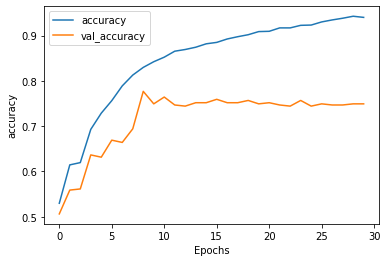

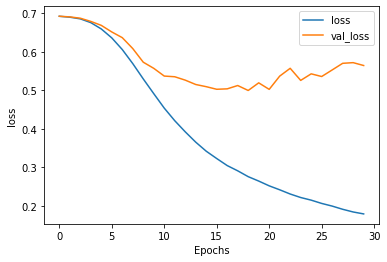

In [14]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Get files for visualizing the network

Once again, you can visualize the sentiment related to all of the subwords using the below code and by heading to http://projector.tensorflow.org/ to upload and view the data.

Note that the below code does have a few small changes to handle the different way text is encoded in our dataset compared to before with the built in Tokenizer.

You may get an error like "Number of tensors (999) do not match the number of lines in metadata (992)." As long as you load the vectors first without error and wait a few seconds after this pops up, you will be able to click outside the file load menu and still view the visualization.

In [15]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [18]:
# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [19]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')